In [1]:
import numpy as np
import scipy.io as sio
from pylab import *

%matplotlib inline
from scipy.signal import welch
from scipy.integrate import simps

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

import itertools

## Part 2 Assignment

### Data Loading

In [2]:
mat = sio.loadmat('data\WLDataCW.mat')

datafile = 'data\WLDataCW.mat'
data_arr = sio.loadmat(datafile)
x_ = data_arr['data']
y_ = data_arr['label'].reshape(-1)

Splitting the dataset into training and test set to contain balanced smaples of Workload 0 and 1 <br>
K Cross Validation will be performed further on the Training Dataset

In [3]:
low_idx = np.argwhere(y_==0).reshape(-1)
medium_idx = np.argwhere(y_==1).reshape(-1)

indices = np.random.permutation(low_idx)

training_idx , test_idx = indices[:144] , indices[144:]

indices = np.random.permutation(medium_idx)
training_idx = np.append(training_idx ,indices[:144] )
test_idx = np.append(test_idx ,indices[144:])

print("Length of Train Set :" ,len(training_idx))
print("Length of Test Set :" ,len(test_idx))


x_train = x_[:,:,training_idx]
y_train = y_[training_idx]

x_test = x_[:,:,test_idx]
y_test = y_[test_idx]

Length of Train Set : 288
Length of Test Set : 72


Custom Dataset class to load and tranform the EEG signals for Training 

In [4]:

import os

# Dataset class to tranform the input and output of Training Data and Labels
class CustomDataset(Dataset):
    def __init__(self, x_arr,y_arr, transform=None, target_transform=None):
        self.data = x_arr
        self.labels = y_arr.reshape(-1)
        self.transform = transform
        self.target_transform = target_transform
        self.sf = 256

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        arr_list = []
        
        for i in  range(self.data.shape[0]):
            arr = self.bandpower(self.data[i,:,idx],self.sf,None,True)
            arr_list.append(arr)
        arr = np.array(arr_list).reshape(-1)
        arr = arr.astype(np.float32)
        label = self.labels[idx].astype(np.float32)
        
        if self.target_transform:
            label = self.target_transform(label)
        return arr, label
    
    
    # The bandpower calculation is inspired by Welch Method described here : https://raphaelvallat.com/bandpower.html
    def bandpower(self,data, sf,window_sec=None, relative=False):
        """

        Parameters
        ----------
        data : 1d-array
            EEG data from a single electrode
        sf : float
            Sampling frequency
        window_sec : float
            Length of each window
            Default Value, window_sec = (1 / min(band)) * 2
        relative : boolean
            Relative Band Power(True) or Absolute (False)

        Return
        ------
        bp_arr : 1-d array
            Array of Absolute and Relative Band Power for Given Frequency Bands - Delta , Theta , Alpha , Beta , Gamma
        """

        
        eeg_bands = {'Delta': (1, 4),
                    'Theta': (4, 8),
                    'Alpha': (8, 12),
                    'Beta': (12, 30),
                    'Gamma': (30, 120)
                    }
        
        bp_arr = []
        for band in ['Delta','Theta','Alpha','Beta','Gamma']:
            low, high = eeg_bands[band][0],eeg_bands[band][1]
            
            # Define window length
            if window_sec is not None:
                nseg = window_sec * sf
            else:
                nseg = (2 / low) * sf
            if nseg > sf:
                nseg = sf
            # Compute the modified periodogram (Welch)
            freqs, psd = welch(data, sf, nperseg = nseg)

            # Frequency resolution
            freq_res = freqs[1] - freqs[0]

            # Find closest indices of band in frequency vector
            idx_band = np.logical_and(freqs >= low, freqs <= high)

            # Integral approximation of the spectrum using Simpson's rule.
            bp = simps(psd[idx_band], dx=freq_res)
            
            # relative to the overal bandpower of signal
            if relative:
                bp /= simps(psd, dx=freq_res)
            bp_arr.append(bp)
        return np.array(bp_arr)

### Neural Network Model

In [5]:
import torch
from torch import nn

class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification,self).__init__()
        self.layer_1 = nn.Linear(310,64)
        self.layer_2 = nn.Linear(64,32)
        self.layer_out = nn.Linear(32,1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(32)
    
    def forward(self,inputs):
        x = self.relu(self.dropout(self.layer_1(inputs)))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = torch.sigmoid(self.layer_out(x))
        
        return x
    
model = BinaryClassification()
    

Training Loop : Batches

In [6]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss , correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        # print(X)
        # print(X.shape)
        pred = model(X)
        y = y.unsqueeze(1)
        loss = loss_fn(pred,y )
        # print(loss)
        train_loss += loss.item()
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        correct += (torch.round(pred) == y).type(torch.float).sum().item()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    train_loss /= num_batches
    correct /= size
    train_losses.append((train_loss))
    train_acc.append(100*correct)

Validation Loop

In [7]:
def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            y = y.unsqueeze(1)
            
            
            test_loss += loss_fn(pred, y).item()
            correct += (torch.round(pred) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    val_losses.append((test_loss))
    val_acc.append(100*correct)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

### Cross Validation

In [8]:
learning_rate = 1e-3
epochs = 20
batch_size = 10
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [9]:
def reset_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

In [10]:
from sklearn.model_selection import KFold
kfold=KFold(n_splits=3,shuffle=True)

for fold,(train_idx,test_idx) in enumerate(kfold.split(x_train[0,0,:])):
    print('------------fold no---------{}----------------------'.format(fold))
  
    # train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    # test_subsampler = torch.utils.data.SubsetRandomSampler(test_idx)
    X = x_train[:,:,train_idx]
    Y = y_train[train_idx]
    x_val = x_train[:,:,test_idx]
    y_val = y_train[test_idx]
    # print(X.shape)
    # print(Y.shape)
    # print(x_val.shape)
    # print(y_val.shape)
    # print(train_idx)
    # print(test_idx)
    
    train_dataloader = DataLoader(CustomDataset(X , Y), batch_size = batch_size, shuffle=True)
    val_dataloader  = DataLoader(CustomDataset(x_val , y_val), batch_size = batch_size, shuffle=True)
    
    train_acc = []
    val_acc = []
    train_losses = []
    val_losses = []
    model.apply(reset_weights)
    
    for t in range(epochs):
        
        print(f"Epoch {t+1}\n----------------------------")
        train_loop(train_dataloader,model,loss_fn,optimizer)
        test_loop(val_dataloader,model,loss_fn)

print("Done")

------------fold no---------0----------------------
Epoch 1
----------------------------
loss: 0.743601  [    0/  192]
loss: 0.696875  [  100/  192]
Test Error: 
 Accuracy: 49.0%, Avg loss: 0.693161 

Epoch 2
----------------------------
loss: 0.754974  [    0/  192]
loss: 0.766184  [  100/  192]
Test Error: 
 Accuracy: 68.8%, Avg loss: 0.664469 

Epoch 3
----------------------------
loss: 0.535604  [    0/  192]
loss: 0.587863  [  100/  192]
Test Error: 
 Accuracy: 79.2%, Avg loss: 0.615284 

Epoch 4
----------------------------
loss: 0.508628  [    0/  192]
loss: 0.658119  [  100/  192]
Test Error: 
 Accuracy: 84.4%, Avg loss: 0.580257 

Epoch 5
----------------------------
loss: 0.528684  [    0/  192]
loss: 0.482886  [  100/  192]
Test Error: 
 Accuracy: 83.3%, Avg loss: 0.533410 

Epoch 6
----------------------------
loss: 0.524264  [    0/  192]
loss: 0.719513  [  100/  192]
Test Error: 
 Accuracy: 86.5%, Avg loss: 0.534738 

Epoch 7
----------------------------
loss: 0.381018  [

Cross Validation Accuracy

In [11]:
np.mean(np.array(val_acc))

85.88541666666666

### Prediction

In [12]:
def predict(dataloader, model):
    model.eval()
    pred_l = []
    with torch.no_grad():
        for X, _ in dataloader:
            pred = model(X)
            pred_l.append(torch.round(pred).item())
    return np.array(pred_l,dtype=uint8)

test_loader  = DataLoader(CustomDataset(x_test , y_test))

pred = predict(test_loader,model)
           

In [13]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix'):
    """
    
    Normalization can be applied by setting `normalize=True`.
    """
    ax = sns.heatmap(cm, annot=True, cmap='Blues')

    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(classes)
    ax.yaxis.set_ticklabels(classes)

    ## Display the visualization of the Confusion Matrix.
    plt.show()

def accuray_report(pred,true,report=True):
    if report:
      print(10*'*')
      print('Confusion Matrix')
      print(10*'*')
      cm = confusion_matrix(true , pred)
      print(cm)
      plot_confusion_matrix(cm,['Low','Medium'])
      
      print(10*'*')
      print('Classification Report')
      print(10*'*')
      print(classification_report(true , pred ))
    return accuracy_score(true,pred)

def save_plot_graphs(experiment_name , train_acc,val_acc,train_losses,val_losses):
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
    ax1.plot(train_losses, label='Training loss')
    ax1.plot(val_losses, label='Validation loss')
    # ax1.xlabel('Epochs')
    # ax1.ylabel('Loss Value')
    ax1.set(xlabel='Epochs', ylabel='Loss Value')
    ax1.legend()
    
    
    ax2.plot(train_acc, label='Training Accuracy')
    ax2.plot(val_acc, label='Validation Accuracy')
    # ax2.xlabel('Epochs')
    # ax2.ylabel('Accuracy')
    ax2.set(xlabel='Epochs', ylabel='Loss Value')
    ax2.legend()
 


**********
Confusion Matrix
**********
[[31  5]
 [ 2 34]]


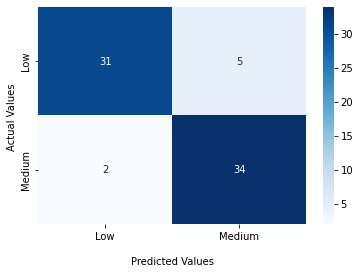

**********
Classification Report
**********
              precision    recall  f1-score   support

           0       0.94      0.86      0.90        36
           1       0.87      0.94      0.91        36

    accuracy                           0.90        72
   macro avg       0.91      0.90      0.90        72
weighted avg       0.91      0.90      0.90        72



0.9027777777777778

In [14]:
accuray_report(pred,y_test)

In [17]:
# save_plot_graphs('experiment_name' , train_acc,val_acc,train_losses,val_losses)